# NOTEARS

NOTEARS（Zheng et al., 2018） は、**因果探索を“勾配最適化”として解く**ことに成功した画期的な手法であり、伝統的な PC（制約ベース）や GES（スコアベース）とは異なる第3のアプローチとして注目されている。

:::{margin}

NOTEARS は Non-combinatorial Optimization via Trace Exponential and Augmented lagRangian for Structure learning の略

:::

:::{card} 論文

[[1803.01422] DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://arxiv.org/abs/1803.01422) (NeurIPS 2018)

:::

従来の因果探索は

- PC：条件付き独立性検定  
- GES：BIC などのスコアによる組合せ探索  

のように **離散最適化** をベースにして因果探索を行う。

NOTEARS はこれを捨て、

> **“DAG である”という制約そのものを連続最適化できるようにした。**


## モデル：線形 SEM

NOTEARS は、次の線形構造方程式モデル（SEM）を仮定する

$$
X = WX + Z,\quad Z\sim \mathcal{N}(0, \sigma^2 I)
$$

- $W$ の非ゼロ要素 $W_{ij}$ がエッジ $j \rightarrow i$ の因果効果を表す  
- $W$ を推定することが、因果グラフを推定することに相当する


## DAGを連続最適化問題へ転換

DAG とはサイクルのない有向グラフであるが、サイクル存在の有無は離散的であり、最適化には扱いにくい。

NOTEARS はこれを **微分可能な制約**として次のように表す。

$$
h(W) = \mathrm{tr}(e^{W \circ W}) - d = 0
$$

- $e^{A}$ は行列指数  
- $W\circ W$ は アダマール積（要素ごとの積）
- $h(W)=0$ が **W が DAG を表すための必要十分条件**となる

この $h(W)$ は滑らかであり、微分可能であるため、**通常の連続最適化（L-BFGS, Adam 等）で扱える**。

## 最適化

最適化するパラメータは $W$ であり、目的関数は次のように与えられる。

$$
\min_{W}
\frac{1}{2n}\|X - WX\|_F^2 + \lambda \|W\|_1
\quad\text{s.t. } h(W)=0
$$

- 最初の項は **再構成誤差（平方誤差）**  
- $\lambda \|W\|_1$ は **スパース化**のための L1 正則化  
- $h(W)=0$ が **DAG 制約**

したがって NOTEARS は

> **「誤差を最小化しつつ DAG を保つ $W$」**

を連続最適化の枠組みで求める手法である。


## 実践

[gCastle](https://gcastle.readthedocs.io/en/latest/castle/castle.html) パッケージにはNOTEARSの計算を効率化させたGOLEMの実装がある

2025-12-09 22:41:34,080 - /home/mitama/notes/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-12-09 22:41:34,110 - /home/mitama/notes/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
2025-12-09 22:41:34,117 - /home/mitama/notes/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2025-12-09 22:41:34,505 - /home/mitama/notes/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:119] - INFO: GPU is available.
2025-12-09 22:41:35,734 - /home/mitama/notes/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/golem.py[line:190] - INFO: Started training for 100000 iterations.
2025-12-09 22:41:35,794 - /home/mitama/notes/.venv/lib/python3.10/site-packages/castle/algorithms/gr

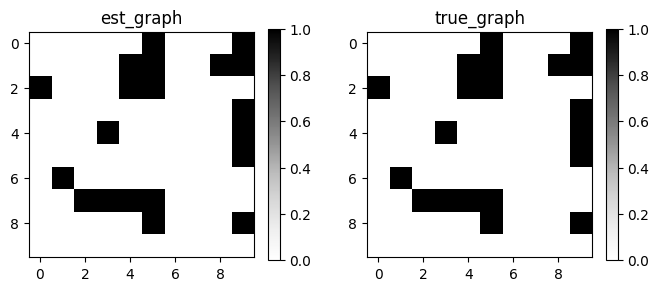

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 20, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


In [1]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import load_dataset
from castle.algorithms import GOLEM

X, true_dag, _ = load_dataset(name='IID_Test')

algo = GOLEM()
algo.learn(X)

# plot DAG
GraphDAG(algo.causal_matrix, true_dag)

# calc Metrics
met = MetricsDAG(algo.causal_matrix, true_dag)
print(met.metrics)

## 参考

- [Zheng, X., Aragam, B., Ravikumar, P. K., & Xing, E. P. (2018). Dags with no tears: Continuous optimization for structure learning. Advances in neural information processing systems, 31.](https://arxiv.org/abs/1803.01422)
- 著者のGithubリポジトリ： [xunzheng/notears: DAGs with NO TEARS: Continuous Optimization for Structure Learning](https://github.com/xunzheng/notears)